In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from scipy.stats import f_oneway
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
import numpy as np

In [6]:
patients_df = pd.read_csv("cleaned_PATIENTS.csv")
patients_df

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26,2135-01-12,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25,NaN,NaN,NaN,0


In [7]:
admissions_df = pd.read_csv("cleaned_ADMISSIONS.csv")
admissions_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,EDOUTTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,2196-04-09 10:06:00,2196-04-09 13:24:00,...,False,False,False,False,False,True,False,False,False,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY ROOM ADMIT,HOME,2160-11-02 01:01:00,2160-11-02 04:27:00,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,CLINIC REFERRAL/PREMATURE,HOME,2131-03-30 19:44:00,2131-03-30 22:41:00,...,False,False,False,False,False,True,False,False,False,False
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,2151-03-05 17:23:00,2151-03-05 21:06:00,...,False,False,False,False,False,True,False,False,False,False
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY ROOM ADMIT,SNF,2128-11-10 23:48:00,2128-11-11 03:16:00,...,False,False,False,False,False,True,False,False,False,False


In [8]:
icustays_df = pd.read_csv("cleaned_ICUSTAYS.csv")
icustays_df

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.248993
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.278796
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.893854
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.059977
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.620243
...,...,...,...,...,...,...,...,...,...,...,...,...
61517,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.189398
61518,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.494236
61519,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.925949
61520,59809,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.334641


In [30]:
# Merging patients_df with icustays_df on SUBJECT_ID
merged_df = pd.merge(patients_df, icustays_df, on="SUBJECT_ID")

# Further merging the above result with admissions_df on [SUBJECT_ID, HADM_ID] to get admission times
final_df = pd.merge(merged_df, admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']], on=["SUBJECT_ID", "HADM_ID"])

# Convert to datetime format for further analysis
final_df['ADMITTIME'] = pd.to_datetime(final_df['ADMITTIME'])
final_df['INTIME'] = pd.to_datetime(final_df['INTIME'])
final_df['OUTTIME'] = pd.to_datetime(final_df['OUTTIME'])
final_df['DOD_HOSP'] = pd.to_datetime(final_df['DOD_HOSP'])
final_df['DOD'] = pd.to_datetime(final_df['DOD'])

# Create a new variable 'MONTH' to analyze data on a monthly basis
final_df['MONTH'] = final_df['ADMITTIME'].dt.month

# Display the first few rows of the final merged dataframe to confirm the merge and new variables
final_df.shape

(61522, 22)

In [31]:
final_df.isna().sum()

ROW_ID_x              0
SUBJECT_ID            0
GENDER                0
DOB                   0
DOD               37333
DOD_HOSP          45309
DOD_SSN           41071
EXPIRE_FLAG           0
ROW_ID_y              0
HADM_ID               0
ICUSTAY_ID            0
DBSOURCE              0
FIRST_CAREUNIT        0
LAST_CAREUNIT         0
FIRST_WARDID          0
LAST_WARDID           0
INTIME                0
OUTTIME               0
LOS                   0
ADMITTIME             0
DISCHTIME             0
MONTH                 0
dtype: int64

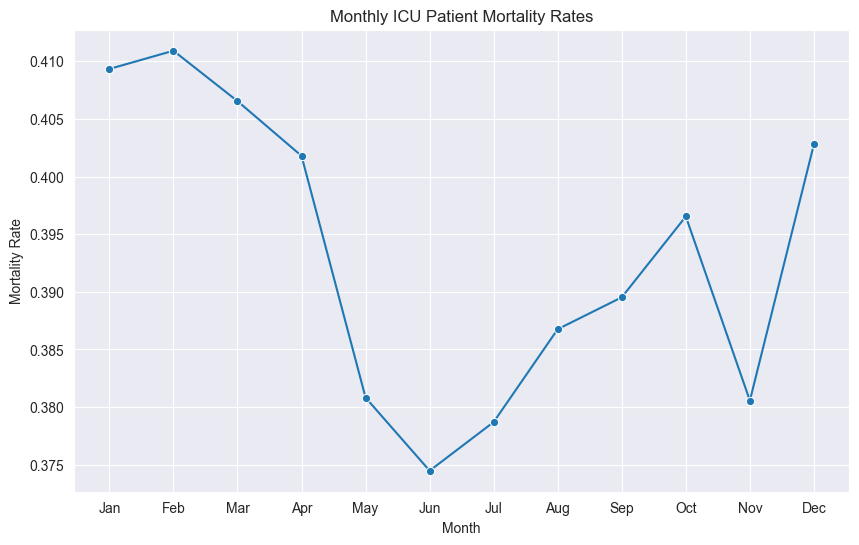

In [25]:
# Aggregating data to calculate monthly mortality rates
# We'll count the number of deaths and total ICU stays per month to calculate the mortality rate
monthly_mortality = final_df.groupby('MONTH').agg(
    deaths=('EXPIRE_FLAG', 'sum'),
    total_icu_stays=('ICUSTAY_ID', 'nunique')
).reset_index()

monthly_mortality['mortality_rate'] = monthly_mortality['deaths'] / monthly_mortality['total_icu_stays']

# Plotting the mortality rate by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_mortality, x='MONTH', y='mortality_rate', marker='o')
plt.title('Monthly ICU Patient Mortality Rates')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.xticks(monthly_mortality['MONTH'], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

/var/folders/kw/fxbbvv5x7lvct1l7rdc18tkw0000gn/T/ipykernel_16539/1498052266.py:28: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  monthly_icu_counts = pd.concat(monthly_icu_counts_list)


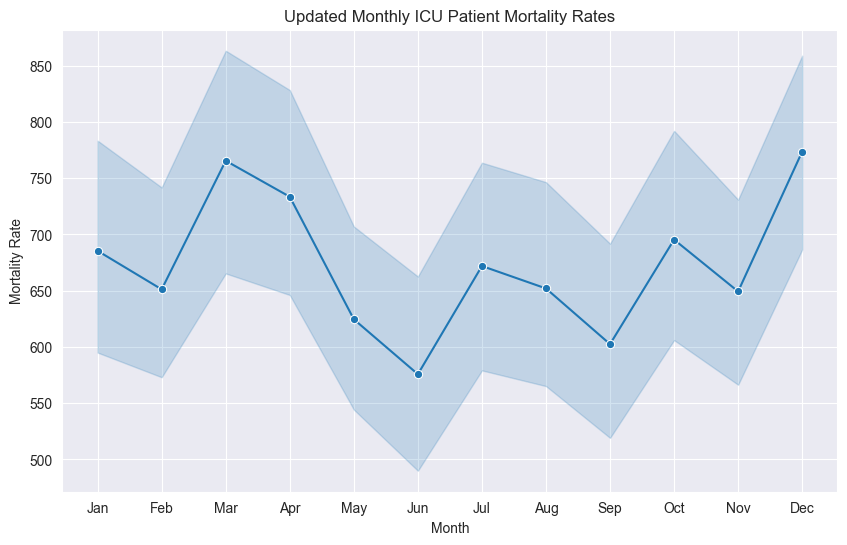

((61522, 22),
       MONTH  deaths  total_icu_stays  mortality_rate
 0         1    2140               48       44.583333
 1         1    2140                9      237.777778
 2         1    2140                1     2140.000000
 3         1    2140               38       56.315789
 4         1    2140                4      535.000000
 ...     ...     ...              ...             ...
 3598     12    2070                5      414.000000
 3599     12    2070                1     2070.000000
 3600     12    2070                3      690.000000
 3601     12    2070                1     2070.000000
 3602     12    2070                1     2070.000000
 
 [3603 rows x 4 columns])

In [33]:
# Initialize a DataFrame to keep track of ICU stays per month for each patient using pd.concat
monthly_icu_counts_list = []

# Create a range of dates for each month in the dataset
date_range = pd.date_range(final_df['ADMITTIME'].min(), final_df['ADMITTIME'].max(), freq='MS')

# Loop over each month and count ICU stays that fall within it, ensuring patients are counted once per month
for start_date in date_range:
    # The end of the month is the start of the next month minus one day
    end_date = start_date + pd.offsets.MonthEnd(0)
    month = start_date.month

    # Check if any part of the ICU stay falls within the month
    icu_stays_this_month = final_df[((final_df['INTIME'] <= end_date) & (final_df['OUTTIME'] >= start_date))]
    
    # Deduplicate patient stays within the same month
    unique_stays_this_month = icu_stays_this_month.drop_duplicates(subset=['SUBJECT_ID', 'MONTH'])

    # Count the number of unique stays
    monthly_count = unique_stays_this_month.groupby('MONTH').agg(
        total_icu_stays=('SUBJECT_ID', 'count')
    ).rename(index={start_date.month: month})

    # Append the monthly count to the tracking list
    monthly_icu_counts_list.append(monthly_count)

# Concatenate the list into a DataFrame
monthly_icu_counts = pd.concat(monthly_icu_counts_list)

# Merge this with the previous monthly_mortality DataFrame to get the corrected total ICU stays per month
monthly_mortality_updated = pd.merge(
    monthly_mortality[['MONTH', 'deaths']],
    monthly_icu_counts,
    on='MONTH',
    how='left'
)

# Recalculate the mortality rate
monthly_mortality_updated['mortality_rate'] = monthly_mortality_updated['deaths'] / monthly_mortality_updated['total_icu_stays']

# Plotting the corrected mortality rate by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_mortality_updated, x='MONTH', y='mortality_rate', marker='o')
plt.title('Updated Monthly ICU Patient Mortality Rates')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')

# Set the x-ticks to match the unique months in the data
unique_months = monthly_mortality_updated['MONTH'].unique()
plt.xticks(unique_months, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][:len(unique_months)])
plt.grid(True)
plt.show()

# Return the shape of the final dataframe and the updated monthly mortality data for reference
final_df.shape, monthly_mortality_updated

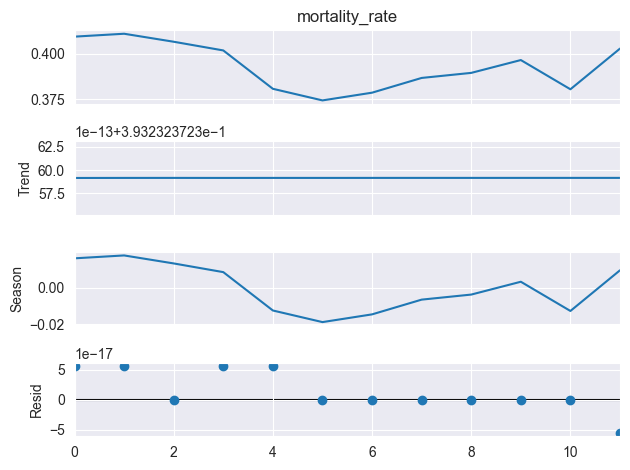

In [29]:
from statsmodels.tsa.seasonal import STL

# Preparing the data for STL decomposition
# STL requires a continuous time series data, so we will create a series with mortality rates for each month
# Note: If there are missing months, the analysis might need adjustment. Assuming continuous months here.

# Ensure the data is sorted by month
monthly_mortality_sorted = monthly_mortality.sort_values('MONTH')

# Performing STL decomposition
stl = STL(monthly_mortality_sorted['mortality_rate'], seasonal=13, period=12)
result = stl.fit()

# Plotting the STL decomposition results
result.plot()
plt.show()